tensor([[ 0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  4,
          4,  5,  5,  5,  0,  1,  2,  6,  7,  8,  5,  4,  3,  9, 10, 11,  0,  1,
          2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
        [ 1,  3,  4,  0,  2,  3,  4,  5,  1,  4,  5,  0,  1,  4,  0,  1,  2,  3,
          5,  1,  2,  4,  6,  7,  8,  0,  1,  2,  9, 10, 11,  5,  4,  3,  0,  1,
          2,  3,  4,  5,  6,  7,  8,  9, 10, 11]])

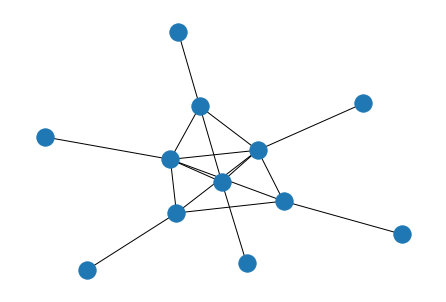

In [1]:

# conda install pytorch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 -c pytorch -y & conda install pyg -c pyg -y & conda install -c anaconda networkx -y & conda install -c conda-forge matplotlib -y

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils
from utils import *
from model import UpdateRule
from datasets import *



meta_set = MetaDataset()



hidden_dim = 64
edge_dim = None
# edge_dim = 8

n_inputs = meta_set.n_inputs
n_outputs = meta_set.n_outputs
height = 2
width = meta_set.n_outputs

update_rule = UpdateRule(
    n_inputs, 
    n_outputs,
    hidden_dim,
    edge_dim,
    network_width=hidden_dim,
    heads = 1
)
update_rule.build_graph(
    height,
    width,
    mode="dense"
)


# cuda_device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
cuda_device = torch.device("cpu")

update_rule = update_rule.to(cuda_device)

# edge_attr = torch.concat(
#     (
#         torch.tensor([[1,0]]*(update_rule.graph.edge_index[0].shape[0]//2)), 
#         torch.tensor([[0,1]]*(update_rule.graph.edge_index[0].shape[0]//2))
#     ), 
# 0).float()
edge_attr = None
# edge_attr = update_rule.edge_attr

update_rule.draw()

update_rule.edge_index

In [2]:
from training import *
optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.001)



x = train_on_meta_set(
    update_rule, optimizer, meta_set, {
        "n_steps": 1,
        "batch_size" : 5,
        "n_epochs" : 1000,
    }, edge_attr = edge_attr#, edge_index=best_edge_index
)

      Epoch 0 |     Loss 0.2544 |     Accuracy 0% |     Network out: [0.331 0.336 0.333] |     Correct:  [1. 0. 0.] |     Network In: []     
      Epoch 100 |     Loss 0.255392 |     Accuracy 20% |     Network out: [0.046 0.407 0.548] |     Correct:  [0. 1. 0.] |     Network In: []     
      Epoch 200 |     Loss 0.251141 |     Accuracy 20% |     Network out: [0.426 0.208 0.366] |     Correct:  [1. 0. 0.] |     Network In: []      
      Epoch 300 |     Loss 0.251178 |     Accuracy 0% |     Network out: [0.235 0.368 0.397] |     Correct:  [0. 0. 1.] |     Network In: []      
      Epoch 400 |     Loss 0.247493 |     Accuracy 20% |     Network out: [0.544 0.367 0.089] |     Correct:  [1. 0. 0.] |     Network In: []     
      Epoch 500 |     Loss 0.256204 |     Accuracy 40% |     Network out: [0.037 0.104 0.859] |     Correct:  [0. 1. 0.] |     Network In: []     
      Epoch 600 |     Loss 0.243652 |     Accuracy 20% |     Network out: [0.422 0.158 0.419] |     Correct:  [0. 0. 1.] |

KeyboardInterrupt: 

x = update_rule.initial_state()
x, loss, network_output, correct, network_in = update_rule(
                    x, 1, DataLoader(TranslateDataset(-1), shuffle=True), edge_attr=edge_attr
                )
print(loss, network_output, correct, network_in)

In [ ]:
import pygad
import pygad.torchga
from training import *
import torch
import time

class EdgeModel(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.edge_mask = nn.Parameter(torch.rand([update_rule.graph.edge_index.shape[1]]))

    def get_edges(self):
        """
        Returns elements of update_rule.edge_index coressponding to the incidces of edge_mask > 0
        """
        # clamp edge mask to be between -1 and 1
        self.edge_mask.clamp(-1, 1)

        return update_rule.edge_index[:, self.edge_mask > 0]

def fitness_func(solution, sol_idx):
    global edge_model
    model_weights_dict = pygad.torchga.model_weights_as_dict(model=edge_model, weights_vector=solution)
    edge_model.load_state_dict(model_weights_dict)

    update_rule = UpdateRule(
        n_inputs, 
        n_outputs,
        hidden_dim,
        edge_dim,
        network_width=hidden_dim,
        heads = 1
    )

    update_rule.build_graph(
        height,
        width,
        mode="dense"
    )
    optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.001)
    loss_integral = train_on_meta_set(
        update_rule, optimizer, meta_set, {
            "n_steps": 1,
            "batch_size" : 5,
            "n_epochs" : 25,
        }, edge_attr = edge_attr, verbose=False, edge_index = edge_model.get_edges()
        )
    
    
    return -loss_integral.item()

best_edge_index = []
def callback_generation(ga_instance):
    global best_edge_index
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    best_edge_index = update_rule.edge_index[:, ga_instance.best_solution()[0] > 0]
    

    # n_nodes = height*width + n_inputs + n_outputs
    # graph = Data(edge_index=edge_index, x=torch.zeros(n_nodes, 1))
    # graph = utils.to_networkx(graph, to_undirected=True, remove_self_loops = True)
    # nx.draw(graph)
    
    

    
edge_model = EdgeModel()

torch_ga = pygad.torchga.TorchGA(model=edge_model,
                           num_solutions=10)

ga_instance = pygad.GA(num_generations=1000000,
                       num_parents_mating=5,
                       initial_population=torch_ga.population_weights,
                       fitness_func=fitness_func,
                       parent_selection_type="sss",
                       crossover_type="single_point",
                       mutation_type="random",
                       mutation_percent_genes=10,
                       keep_parents=-1,
                       random_mutation_min_val = -1,
                       random_mutation_max_val = 1,
                       on_generation=callback_generation)
ga_instance.run()


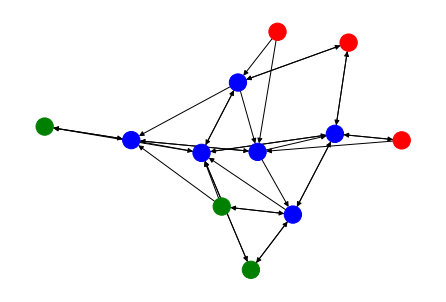

In [ ]:

n_nodes = height*width + n_inputs + n_outputs
nodes = torch.zeros(n_nodes, 1)

color_map = ["blue"] * height*width + ["green"] * n_inputs + ["red"] * n_outputs

graph = Data(edge_index=best_edge_index, x=nodes)
graph = utils.to_networkx(graph, to_undirected=False, remove_self_loops = True)

nx.draw(graph, arrows=True, node_color=color_map)

In [ ]:
import torch
best_edge_index = torch.tensor([[ 0,  0,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  1,  2,  0,  1,
          2,  6,  6,  7,  8,  8,  8,  5,  5,  3,  9,  9, 10, 10, 11, 11,  0,  1,
          3,  7,  8,  9, 10, 11],
        [ 1,  4,  3,  5,  1,  5,  0,  1,  4,  0,  2,  5,  1,  2,  6,  6,  7,  7,
          8,  1,  2,  0,  0,  1,  2, 10, 11, 11,  4,  3,  5,  4,  5,  3,  0,  1,
          3,  7,  8,  9, 10, 11]])

In [ ]:
edge_model.get_edges()

tensor([[ 0,  0,  1,  1,  1,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  1,  2,  0,
          1,  2,  6,  6,  7,  8,  8,  8,  5,  5,  3,  9, 10, 10, 11, 11,  0,  1,
          3,  7,  8,  9, 10, 11],
        [ 1,  4,  3,  4,  5,  1,  5,  0,  1,  4,  0,  2,  5,  1,  2,  6,  6,  7,
          7,  8,  1,  2,  0,  0,  1,  2, 10, 11, 11,  5,  5,  4,  5,  3,  0,  1,
          3,  7,  8,  9, 10, 11]])

In [ ]:

update_rule.edge_index

tensor([[ 0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  4,
          4,  5,  5,  5,  0,  1,  2,  0,  1,  2,  0,  1,  2,  6,  6,  6,  7,  7,
          7,  8,  8,  8,  5,  4,  3,  5,  4,  3,  5,  4,  3,  9,  9,  9, 10, 10,
         10, 11, 11, 11,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
        [ 1,  3,  4,  0,  2,  3,  4,  5,  1,  4,  5,  0,  1,  4,  0,  1,  2,  3,
          5,  1,  2,  4,  6,  6,  6,  7,  7,  7,  8,  8,  8,  0,  1,  2,  0,  1,
          2,  0,  1,  2,  9,  9,  9, 10, 10, 10, 11, 11, 11,  5,  4,  3,  5,  4,
          3,  5,  4,  3,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]])